In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [ ]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [ ]:
# Load simulation data with full morphologies
base_dir_plot_morph = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/imem_plot_data'

# Imem plot data for selected frequencies contains morphology information for plotting
morph_plot_file_paths = [
    os.path.join(base_dir_plot_morph, f'plot_imem_{i}.npy')
    for i in range(8)
]

In [ ]:
# Can only load some selected cells at a time for plotting
def load_plot_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [ ]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5"]

cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)"
}

short_cell_names = {
    'L4_BP_bIR215_5': 'L4 BP',
    "L5_MC_bAC217_1": "L5 MC",
    "L5_TTPC2_cADpyr232_3": "L5 TTPC",
    "L5_NGC_bNAC219_5": "L5 NGC"
}

cell_vmem_colors = {
    'L4_BP_bIR215_5': "tab:pink",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown'
}

cell_cdm_colors = {
    'L4_BP_bIR215_5': "tab:purple",
    "L5_MC_bAC217_1": "tab:blue",
    "L5_TTPC2_cADpyr232_3": "tab:green",
    "L5_NGC_bNAC219_5": 'tab:red'
}

In [ ]:
def plot_morph_and_amp(morph_plot_file_paths, amp_data, amp_type, selected_cells):
    """Plot morphology examples (A) and amplitude spectra (B). Can be either cdm amplitudes or vmem amplitudes. Vmem amplitudes used in Fig1."""
    
    morph_dict = load_plot_data_from_files(morph_plot_file_paths, selected_cells)

    unique_cells = list(morph_dict.keys())
    if selected_cells:
        unique_cells = [cell for cell in unique_cells if cell in selected_cells]

    num_cells = len(unique_cells)
    assert num_cells == 4, "This function expects exactly 4 selected cells for subplot A."

    # --- Figure layout: 2 rows, 4 columns ---
    fig = plt.figure(figsize=(8, 4))
    gs = fig.add_gridspec(
        2, 4,
        width_ratios=[0.8, 0.8, 0.8, 4],
        height_ratios=[1.6, 0.4],
        wspace=0.8, hspace=0.25
    )

    # --- Morphology subplots (same layout as original) ---
    axs_morph = []
    ax0 = fig.add_subplot(gs[:, 0])      # L4 BP
    ax1 = fig.add_subplot(gs[0, 1])      # L5 MC
    ax2 = fig.add_subplot(gs[:, 2])      # L5 TTPC
    ax3 = fig.add_subplot(gs[1, 1])      # L5 NGC
    axs_morph.extend([ax0, ax1, ax2, ax3])

    all_x, all_z = [], []

    # --- Plot morphologies ---
    for i, label in enumerate(unique_cells):
        # Estimate figure height in data units for conversion:
        ax1 = axs_morph[1]  # L5 MC axis
        ax2 = axs_morph[2]  # L5 TTPC axis
        ax3 = axs_morph[3]  # L5 NGC axis
        fig.canvas.draw()  # Ensure layout positions are initialized

        z_range = np.ptp(all_z) if len(all_z) > 0 else 1000  # fallback

        # Move MC downward
        move_fraction_mc = 19 / z_range
        pos_mc = ax1.get_position()
        new_pos_mc = [pos_mc.x0, pos_mc.y0 - move_fraction_mc, pos_mc.width, pos_mc.height]
        ax1.set_position(new_pos_mc)

        # Move TTPC downward
        move_fraction_ttpc = 7 / z_range  
        pos_ttpc = ax2.get_position()
        new_pos_ttpc = [pos_ttpc.x0, pos_ttpc.y0 - move_fraction_ttpc, pos_ttpc.width, pos_ttpc.height]
        ax2.set_position(new_pos_ttpc)

        # Move NGC upward
        move_fraction_ngc = 40 / z_range
        pos_ngc = ax3.get_position()
        new_pos_ngc = [pos_ngc.x0, pos_ngc.y0 + move_fraction_ngc, pos_ngc.width, pos_ngc.height]
        ax3.set_position(new_pos_ngc)

        
        ax = axs_morph[i]
        cell_data = morph_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        color = cell_vmem_colors[label]

        # Draw morphology
        for idx in range(totnsegs):
            ax.plot(x[idx], z[idx], c=color, lw=1)

        # Soma marker
        ax.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0],
                'o', color='black', markersize=3, label = 'Soma')

        # Collect extents for scale bar placement
        all_x.extend(x.flatten())
        all_z.extend(z.flatten())

        # Clean style: no axes or frame
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_frame_on(False)
        ax.set_aspect('equal', adjustable='box')

        # Add cell title
        ax.set_title(f'{cell_names[label]}', fontsize=7)
    
    # --- Ensure shared y-axis limits across morphology plots ---
    all_x = np.array(all_x)

    # Determine common axis limits
    x_min, x_max = np.min(all_x), np.max(all_x)

    # Apply same limits to all morphology subplots
    for ax in axs_morph:
        ax.set_xlim(x_min, x_max)

    # --- Shared scale bar ---
    scale_bar_length = 100  # µm  
    ax_xlim = ax0.get_xlim()
    ax_ylim = ax0.get_ylim()
    # Determine scale bar x-position 
    scale_bar_x_start = ax_xlim[0] + 0.10 * (ax_xlim[1] - ax_xlim[0])
    scale_bar_x_end = scale_bar_x_start + scale_bar_length
    
    # Determine scale bar y-position 
    if len(all_z) > 0:
        scale_bar_y = np.min(all_z) - 0.05 * np.ptp(all_z)
    else:
        # Fallback if no data was collected, or use a fixed offset from the bottom limit
        scale_bar_y = ax_ylim[0] - 200 
    
    # Put scale bar on bottom-left subplot (L4 BP) -> ax0
    ax0.plot([scale_bar_x_start, scale_bar_x_end],
             [scale_bar_y, scale_bar_y], color='k', lw=1)
    ax0.text((scale_bar_x_start + scale_bar_x_end) / 2, 
             scale_bar_y - 40, # 40 µm offset below the bar
             f'{scale_bar_length} µm', fontsize=9,
             va='top', ha='center')
    
    # Create a single legend for Soma, placed at the bottom-left of the figure
    dot_handle = plt.Line2D([], [], color='black', marker='o', linestyle='None', markersize=3, label='Soma')
    fig.legend(handles=[dot_handle],
            loc='center',  # ignored when bbox_to_anchor is used
            bbox_to_anchor=(0.1, 0.23),  # (x, y) in figure coordinates
            fontsize=7, frameon=True)

    # Ensure all morphology plots can contain the scale bar if placed far below.
    current_ymin, current_ymax = ax0.get_ylim()
    if scale_bar_y - 10 < current_ymin:
        ax0.set_ylim(scale_bar_y - 10, current_ymax)

    # --- Add subplot label A ---
    ax0.text(-0.35, 1.2, 'A', transform=ax0.transAxes,
             fontsize=10, fontweight='bold')

    # --- Subplot B: amplitude spectra ---
    axB = fig.add_subplot(gs[:, 3])

    for cell_name, data in amp_data.items():
        if cell_name in selected_cells:
            if amp_type == 'soma_amp':
                frequencies = data['freq']
                ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'
                color = cell_vmem_colors[cell_name]
            elif amp_type == 'cdm':
                frequencies = data['frequency']
                ylab = "Dipole Moment Amplitude [A·m]"
                color = cell_cdm_colors[cell_name]

            amplitudes = data[amp_type]
            axB.loglog(frequencies, amplitudes,
                       label=f'{short_cell_names[cell_name]}', color=color)

    axB.set_xlabel('Frequency [Hz]')
    axB.set_ylabel(ylab)
    axB.set_xlim(left=frequencies[0], right=frequencies[-1])
    axB.grid(linestyle='--', linewidth=0.5)
    axB.legend(loc='upper right', ncol=1, fontsize=7, frameon=False)
    axB.text(-0.1, 1.1, 'B', transform=axB.transAxes,
             fontsize=10, fontweight='bold')

    # Equal aspect for amplitude plot
    axB.set_aspect('equal', adjustable='box')
    
    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/neocortical/fig1.pdf')
    plt.show()


<>:145: SyntaxWarning: invalid escape sequence '\m'
<>:145: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_44619/1385898568.py:145: SyntaxWarning: invalid escape sequence '\m'
  ylab = 'Soma $V_\mathrm{m}$ Amplitude [mV]'


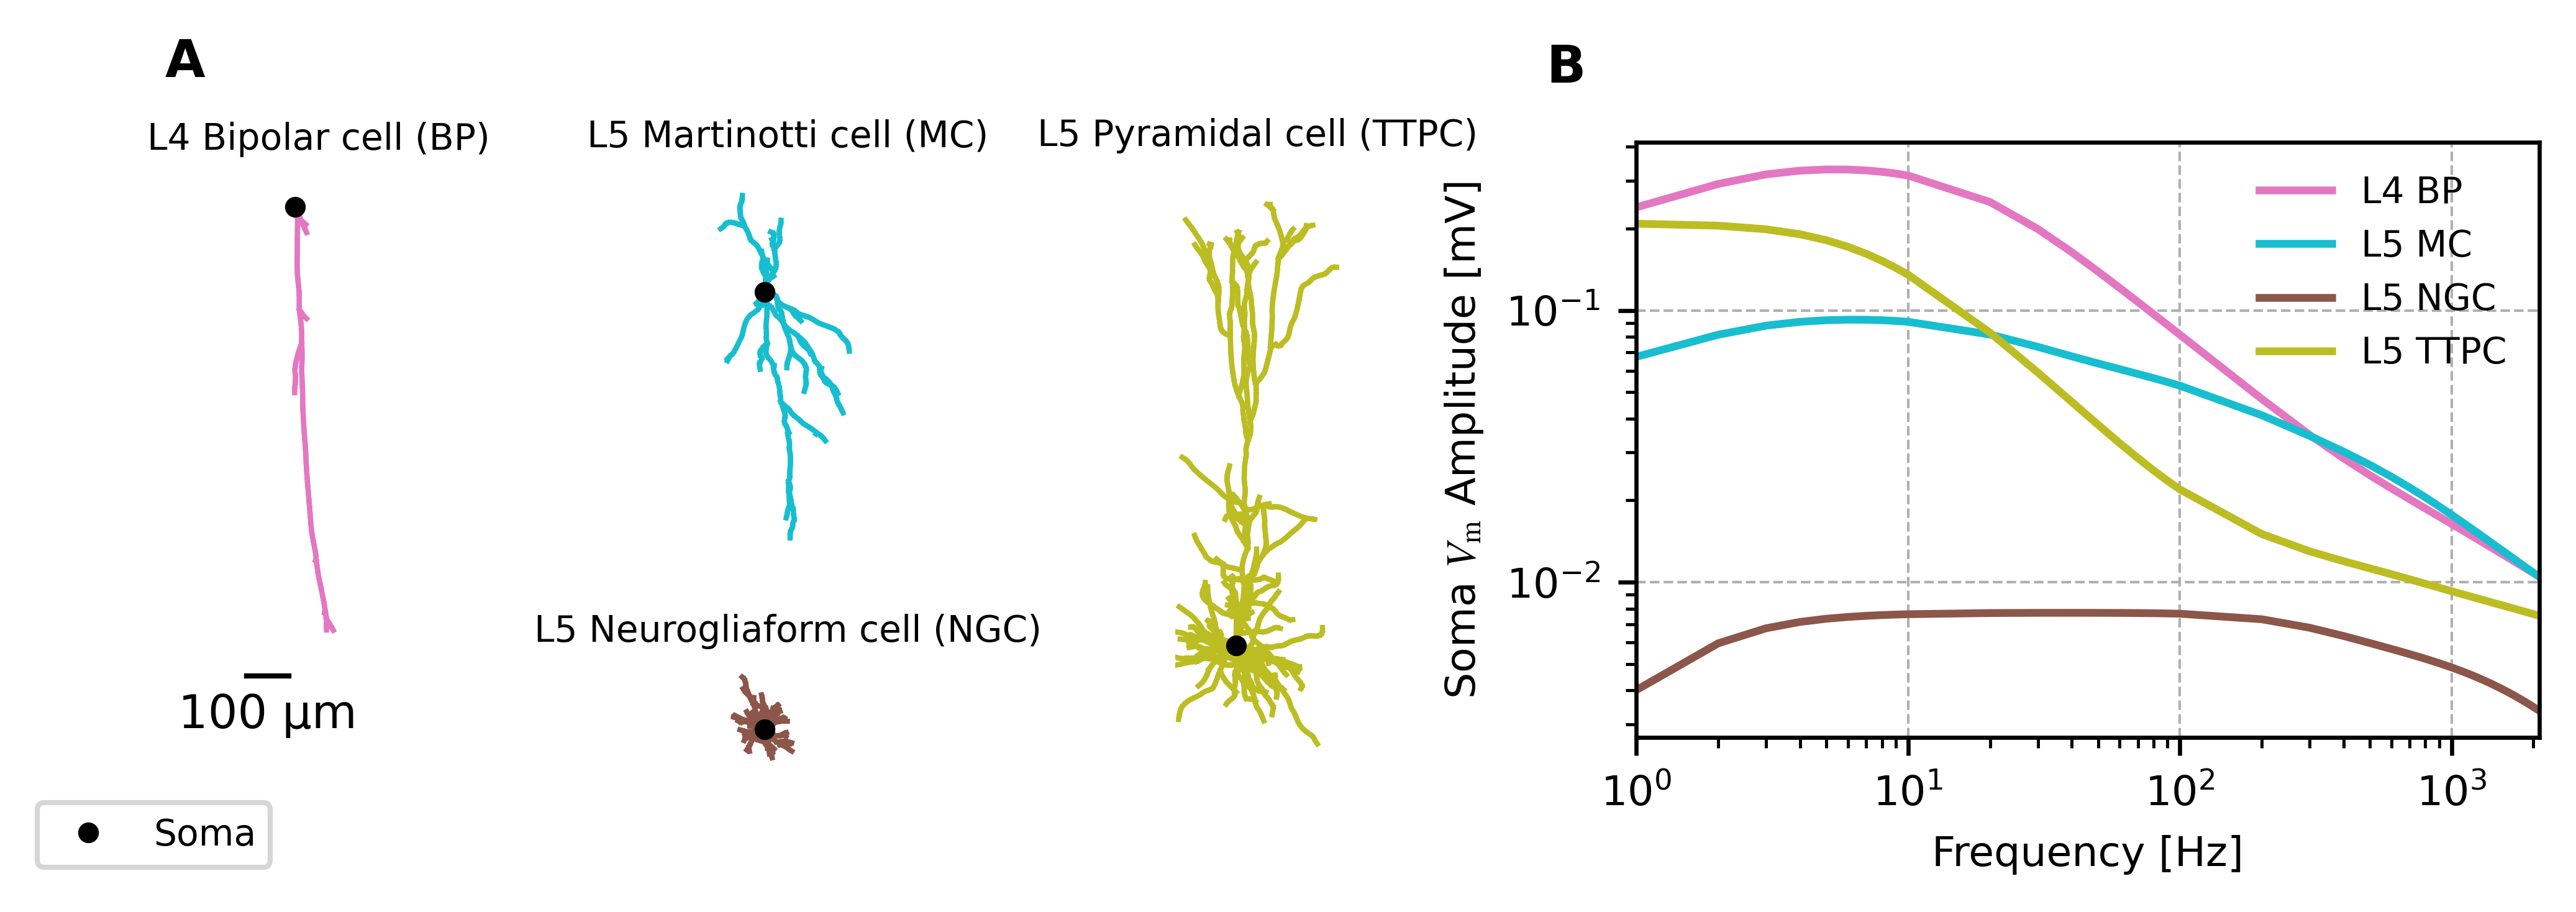

In [ ]:
plot_morph_and_amp(morph_plot_file_paths, vmem_amp_data, 'soma_amp', selected_cells)